In [1]:
import os
import numpy as np
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../data/"

In [3]:
testFile = os.path.join(DATA_DIR,"test.txt")

In [4]:

#I noticed an empty line in the text file denotes end of a sentence. So I am reading the file and 
#returning all sentences present in the file.

def read_file(filename):
    #open the file
    fpt = open(filename,"r",encoding="utf8")
    

    #store the current sentence in this list
    currentSentence=[]
    #list to store all sentences in the file
    allSentences=[]
    for line in fpt:
        
        lineSplit = line.split()
        
        #if line is empty it indicates end of the sentence. Append the current sentence to allSentences and reinitialize
        #currentSentence to an empty list
        if len(lineSplit)==0:
            allSentences.append(currentSentence)
            currentSentence=[]
        #else add the word to the corresponding BIO label in the dictionary and add the word to the current sentence
        else:
            word = lineSplit[0]
            currentSentence.append(word)
    

    fpt.close()
    
    return allSentences

In [5]:
test_sentences = read_file(testFile)

In [6]:
print(test_sentences[0])

['&', 'gt', ';', '*', 'The', 'soldier', 'was', 'killed', 'when', 'another', 'avalanche', 'hit', 'an', 'army', 'barracks', 'in', 'the', 'northern', 'area', 'of', 'Sonmarg', ',', 'said', 'a', 'military', 'spokesman', '.']


In [7]:
#preprocess the sentences as we had done for training. However in this case any words like urls, twitter @s or punctuations
#in the sentence are marked as <UNK> or unknown because at test time we need a prediction for every word. 
#These will be predicted as 'O'. Also make all words lower case
def pre_process(sentence):
    result = []
    for word in sentence:
        word = re.sub(r'^https?:\/\/.*[\r\n]*', '', word)
        word = re.sub('@[^\s]+','',word)
        if word.isalpha() and len(word)>0:
            result.append(word.lower())
        else:
            result.append("<UNK>")
            
    return result

In [8]:

for i,sentence in enumerate(test_sentences):

    processedSen = pre_process(sentence)
    test_sentences[i]=processedSen

In [9]:
print(test_sentences[0])

['<UNK>', 'gt', '<UNK>', '<UNK>', 'the', 'soldier', 'was', 'killed', 'when', 'another', 'avalanche', 'hit', 'an', 'army', 'barracks', 'in', 'the', 'northern', 'area', 'of', 'sonmarg', '<UNK>', 'said', 'a', 'military', 'spokesman', '<UNK>']


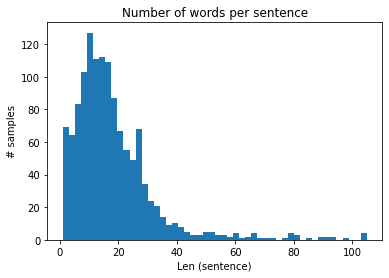

In [10]:

# Plot sentence by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Number of words per sentence')
plt.xlabel('Len (sentence)')
plt.ylabel('# samples')
plt.show()



In [11]:
#load in the word2Idx,idx2Word,label2Idx and idx2Label dictionaries we had created on training data
#use it to convert the test sentences to list of indices as expected by a Bi-LSTM model
with open('../data/word2Idx.pickle', 'rb') as handle:
    word2Idx = pickle.load(handle)
    
with open('../data/idx2Word.pickle', 'rb') as handle:
    idx2Word = pickle.load(handle)

with open('../data/label2Idx.pickle', 'rb') as handle:
    label2Idx = pickle.load(handle)
    
with open('../data/idx2Label.pickle', 'rb') as handle:
    idx2Label = pickle.load(handle)

In [12]:
#function to map the sentence to their correspond ids from the dictionary created above
def map_to_idx(sentence):
    sentenceToIdx=[]
    
    for i,word in enumerate(sentence):
        if word in word2Idx:
            wordIdx = word2Idx[word]
        elif word.lower() in word2Idx:
            wordIdx = word2Idx[word.lower()]
        else:
            wordIdx = word2Idx['UNKNOWN_TOKEN']

        sentenceToIdx.append(wordIdx)
        
    return sentenceToIdx

In [24]:
#create the dataset by mapping words and tags to the ids
X_test = []
samples=len(test_sentences)
for i in range(samples):
    
    sentence=test_sentences[i]
    sentenceToIdx = map_to_idx(sentence)
    X_test.append(sentenceToIdx)

In [25]:
#based on the above graph I decided setting the max sentence length to 105 is a good idea
#pad all sentences to the same length of 105

def padding(sentences, max_len, padding='post'):
    padded_sentences = pad_sequences(sentences, max_len,padding='post')
    return padded_sentences


X_test = padding(X_test, 105, padding='post')

In [26]:
#sanity check that we have the done the mapping right and created the right dataset
i=1200
#print(X[i])
#print(y[i])
print(test_sentences[i])

print([idx2Word[w] for w in X_test[i]])

['rt', '<UNK>', 'kiiingpin', '<UNK>', '<UNK>', 'i', 'want', 'to', 'be', 'someone', '<UNK>', 's', 'favorite', 'person', 'to', 'talk', 'to']
['rt', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'i', 'want', 'to', 'be', 'someone', 'UNKNOWN_TOKEN', 's', 'favorite', 'person', 'to', 'talk', 'to', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDI

In [27]:
#number of sentences, length of each sentence
print(X_test.shape)

(1287, 105)


In [28]:
EMBEDDING_DIM=100
BATCH = 32
#set from the graph above
max_seq_len = 105
num_labels = len(label2Idx)

In [18]:
# Loading glove embeddings
embeddings_index = {}
f = open("../embeddings/glove.6B.100d.txt", encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0] # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') #50d vectors   
    #representing the word
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word2Idx), EMBEDDING_DIM))

# Word embeddings for the tokens
for word,i in word2Idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)

In [30]:
test_dataset = test_dataset.batch(BATCH)

In [31]:
#define the model which has the following architecture
#Embedding->BiLSTM->Dense
class NERmodel(tf.keras.Model):
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, num_labels, weights):

        super(NERmodel, self).__init__() 
        self.embedding = layers.Embedding(input_dim=embed_input_dim,
                                          output_dim=embed_output_dim, weights=weights,
                                          input_length=max_seq_len, trainable=True, mask_zero=True)        

        self.bilstm = layers.Bidirectional(layers.LSTM(512,return_sequences=True))
    
        self.dense = layers.Dense(num_labels)

    def call(self, inputs):

        x = self.embedding(inputs) # batchsize, max_seq_len,embedding_output_dim
        x = self.bilstm(x) #batchsize, max_seq_len, hidden_dim_bilstm
        logits = self.dense(x) #batchsize, max_seq_len, num_labels
        return logits

In [32]:


#I need to convert the indices my model will predict back to its actual class
#this is what the function below does
#for eg 0->'O'
#       1->'B-location'
#this is done for the predictions
def idx_to_label(predictions, idx2Label):
    
    #store all the predictions in this list
    label_pred = []
    
    for i,pred_batch in enumerate(predictions):
        
        for sentence in pred_batch:
            #store the predictions for a sentence in this
            sentence_pred = []
            for i in sentence:
                sentence_pred.append(idx2Label[i])
            #at the end of the sentence,append the predictions
            label_pred.append(sentence_pred)
                    
    return label_pred

#load the model weights to test
test_model =  NERmodel(max_seq_len=max_seq_len, embed_input_dim=len(word2Idx), embed_output_dim=EMBEDDING_DIM, weights=[embedding_matrix], num_labels=num_labels)
test_model.load_weights(f"../models/best-lstm-v8")

#list to store the prediction labels
pred_labels = []

for sentences_batch in test_dataset:
    
    logits = test_model(sentences_batch)
    temp1 = tf.nn.softmax(logits)
    preds = tf.argmax(temp1, axis=2)
    #true_labels.append(np.asarray(labels_batch))
    pred_labels.append(np.asarray(preds))

label_pred = idx_to_label(pred_labels, idx2Label)


In [35]:
#write the predictios to a file such that there is one to one correspondence between a line in the test_predictions.txt and 
#test.txt file
ftest = open("../data/test_predictions.txt","a")
for i,s in enumerate(test_sentences):

    prediction = label_pred[i][0:len(s)]
    for pred in prediction:
        ftest.write("%s\n" % pred)
    ftest.write("\n")
    #assert len(prediction)==len(s)
    #ftest.write
ftest.close()
    